# Image Classification of COVID-19 X-rays

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.12.0'

#### Load Image Data

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# DATA_LIST = os.listdir('/content/gdrive/My Drive/Colab Notebooks/all/train')
# DATASET_PATH  = '/content/gdrive/My Drive/Colab Notebooks/all/train'
# TEST_DIR =  '/content/gdrive/My Drive/Colab Notebooks/all/test'
DATA_LIST = os.listdir('../Data/Covid_Data_GradientCrescent/all/train')
DATASET_PATH  = '../Data/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  '../Data/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 256  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 200
LEARNING_RATE = 0.001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   channel_shift_range = 20,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    brightness_range = [0.5,1.5],    
                                   validation_split = 0.2,fill_mode='nearest')



train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


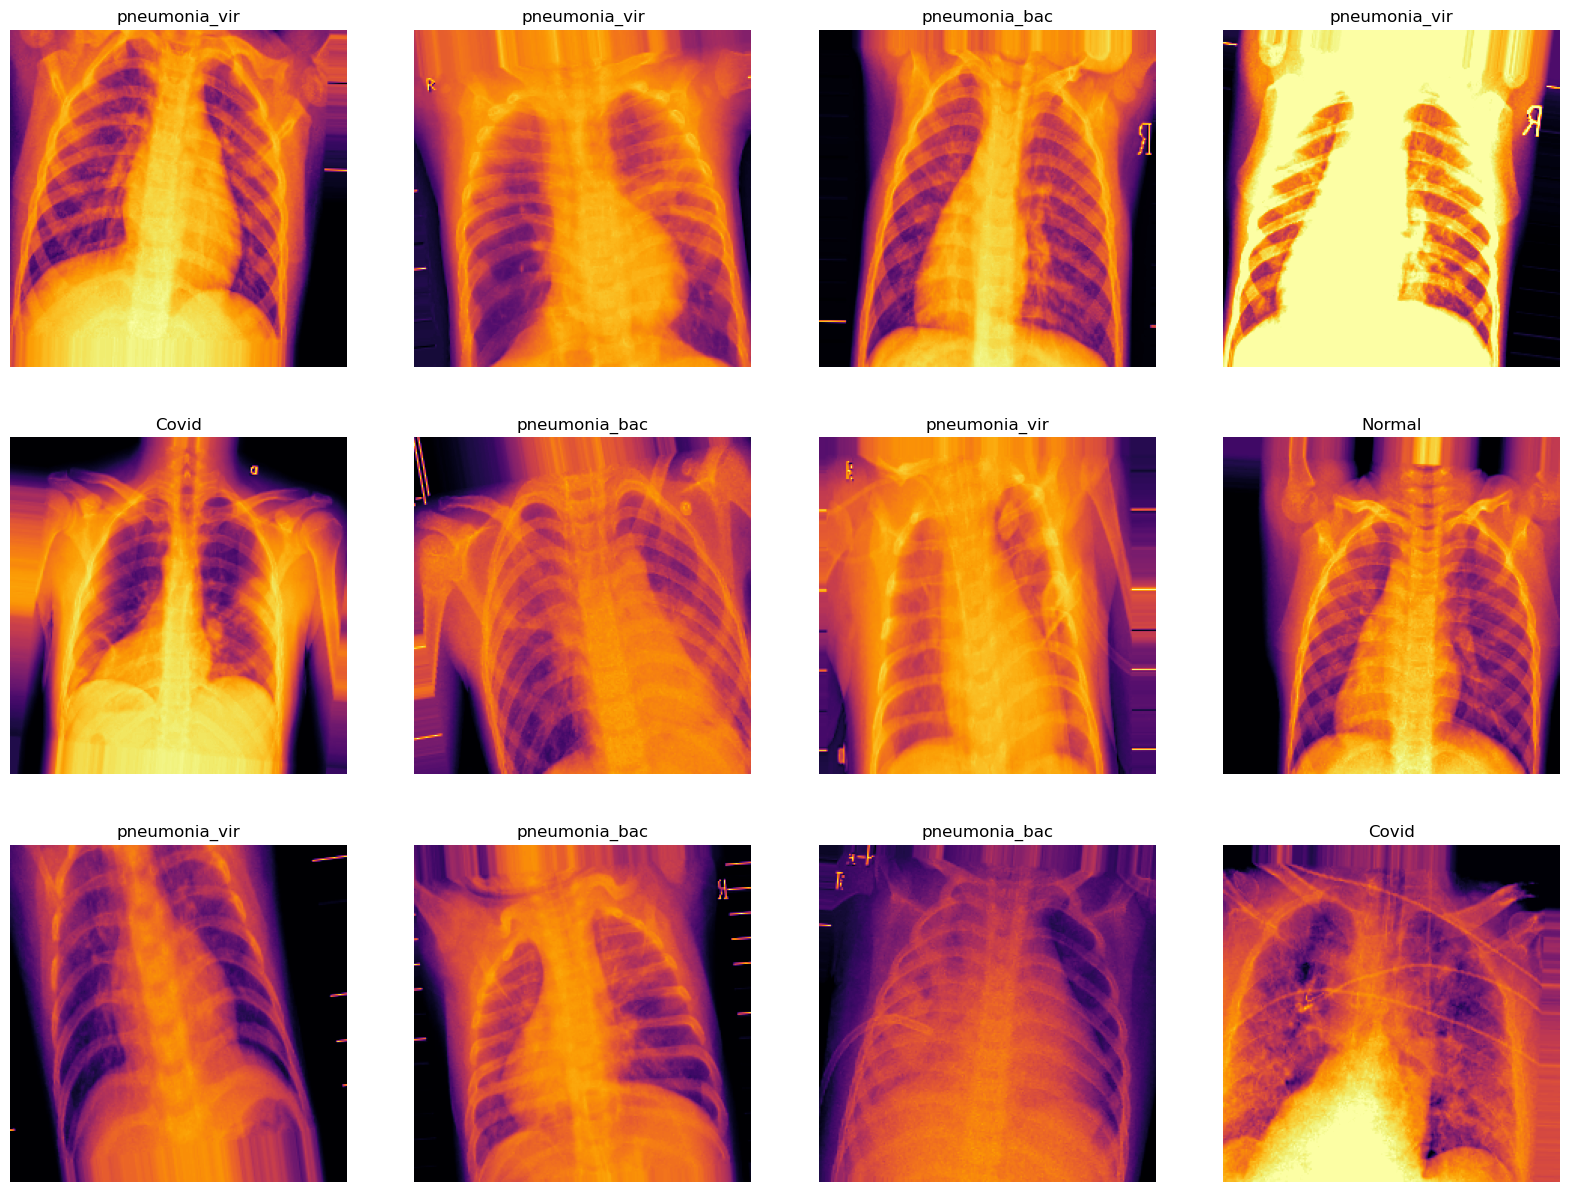

In [4]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]
    
    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(tf.image.rgb_to_grayscale(img_feature[i]), cmap='inferno')
        plt.title("Covid" if np.argwhere(img_label[i] == 1).item()== 0 else (
            "Normal" if np.argwhere(img_label[i] == 1).item()== 1 else (
            "pneumonia_bac" if np.argwhere(img_label[i] == 1).item()== 2 else "pneumonia_vir" )))
        plt.axis("off")

image_plot(train_batches,12)

#### Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [5]:
from tensorflow.keras import layers, models
VGG16_base= tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3))
inputs = VGG16_base.input  # Use VGG16 input
x = VGG16_base.output  # Start with VGG16 output
VGG16_base.trainable = False  # Freeze the VGG16 layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', name='feature_dense1')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', name='feature_dense2')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', name='feature_dense4')(x)
outputs = layers.Dense(4, activation='softmax')(x) 

# Final model
model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# VGG16= tf.keras.applications.VGG16(include_top=False,weights="imagenet",input_shape=(224, 224, 3))
# model = tf.keras.models.Sequential([
#   VGG16,
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(256, activation='relu', name='feature_dense1'),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(128, activation='relu', name='feature_dense2'),
#   tf.keras.layers.Dropout(0.1),
#   tf.keras.layers.Dense(32, activation='relu', name='feature_dense4'),
#   tf.keras.layers.Dense(4, activation='softmax', name='softmax')
# ])
# model.summary()

In [7]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

#### Train Model

In [8]:
#FIT MODEL
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_all_best.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10, verbose=1)

callbacks_list = [checkpoint,early]
history = model.fit(train_batches,  epochs=NUM_EPOCHS, validation_data=valid_batches,shuffle=False, 
        verbose=True, callbacks=callbacks_list) 

Epoch 1/200


2024-03-12 00:40:29.395961: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - ETA: 0s - loss: 1.8139 - accuracy: 0.2222
Epoch 1: accuracy improved from -inf to 0.22222, saving model to model/vgg16_all_best.h5
1/1 [==============================] - 28s 28s/step - loss: 1.8139 - accuracy: 0.2222 - val_loss: 1.3785 - val_accuracy: 0.3519
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.4043 - accuracy: 0.2778
Epoch 2: accuracy improved from 0.22222 to 0.27778, saving model to model/vgg16_all_best.h5
1/1 [==============================] - 28s 28s/step - loss: 1.4043 - accuracy: 0.2778 - val_loss: 1.3574 - val_accuracy: 0.2963
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.2685
Epoch 3: accuracy did not improve from 0.27778
1/1 [==============================] - 28s 28s/step - loss: 1.3678 - accuracy: 0.2685 - val_loss: 1.3079 - val_accuracy: 0.4815
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.3438 - accuracy: 0.3796
Epoch 4: accuracy improved f

#### Plot Accuracy and Loss During Training

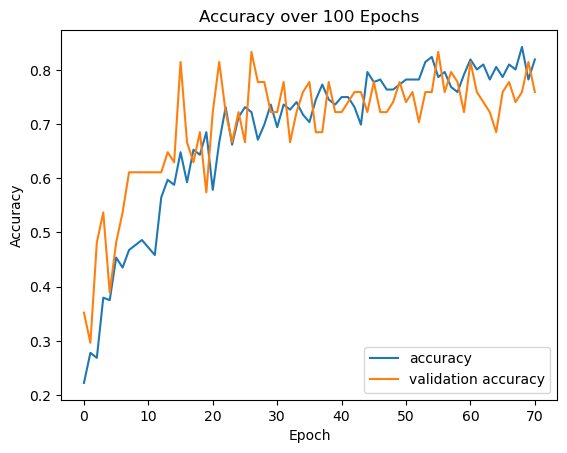

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over 100 Epochs')
plt.legend(loc='lower right')


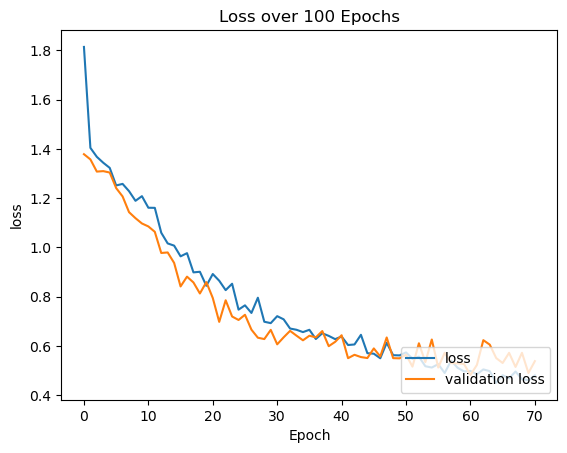

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss over 100 Epochs')
plt.legend(loc='lower right')

#### Testing Model

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  channel_shift_range = 20,
                                   horizontal_flip = True,
                                   zoom_range = 0.1,
                                   validation_split = 0.2,fill_mode='nearest')

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.


/var/folders/sd/44lgkn8j12v2l8tck1dj0r340000gn/T/ipykernel_58491/2545781131.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


36/36 [==============================] - 5s 126ms/step - loss: 0.5682 - accuracy: 0.8056
Test loss: 0.5682176947593689
Test accuracy: 0.8055555820465088


## Confusion Matrix

## TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [12]:
from sklearn.manifold import TSNE
from tensorflow.keras import models,layers,optimizers
intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense4').output)

tsne_eval_generator = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")



labels = []
tsne_inputs = []
for i in range(len(tsne_eval_generator)):
    feature, label = tsne_eval_generator[i]
    y = intermediate_layer_model(feature)
    if np.argwhere(label[0] == 1).item()== 0:
        labels.append("Covid")
    elif np.argwhere(label[0] == 1).item()== 1:
        labels.append("Normal")
    elif np.argwhere(label[0] == 1).item()== 2:
        labels.append("pneumonia_bac")
    else:
        labels.append("pneumonia_vir")
    tsne_inputs.append(y[0])
tsne_inputs = np.array(tsne_inputs)


Found 270 images belonging to 4 classes.


In [13]:
tsne_result = TSNE(n_components=2, method='exact').fit_transform(tsne_inputs)
tsne_result.shape

(270, 2)

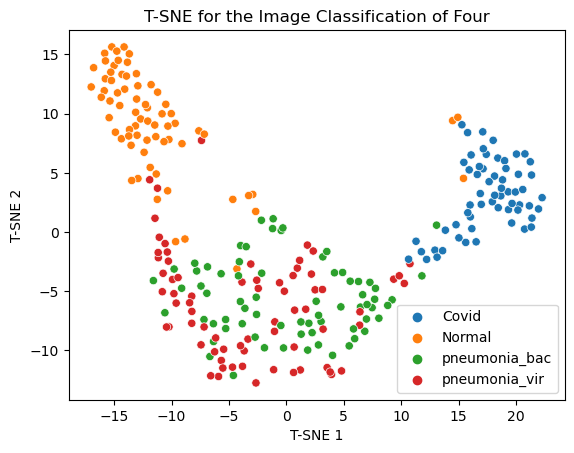

In [14]:
tsne_result_df = pd.DataFrame({'T-SNE 1': tsne_result[:,0], 'T-SNE 2': tsne_result[:,1],
                               'label': labels})
sns.scatterplot(x='T-SNE 1', y='T-SNE 2', hue='label', data=tsne_result_df)
plt.title("T-SNE for the Image Classification of Four")
plt.legend()
plt.show()

In [15]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if layer is convolutional
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

last_conv_layer_name = find_last_conv_layer(model)
print("Last Conv Layer:", last_conv_layer_name)

Last Conv Layer: block5_conv3


## Heatmap

In [16]:
import cv2
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.image as mpimg
def get_heatmap(model, img_path, layer_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred_class = np.argmax(model.predict(img))

    heatmap_model = tf.keras.models.Model([model.inputs], [VGG16_base.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img)
        if pred_class is None:
            pred_class = tf.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = np.squeeze(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.expand_dims(heatmap, axis=-1) 
    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img[0]) 
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

    return superimposed_img


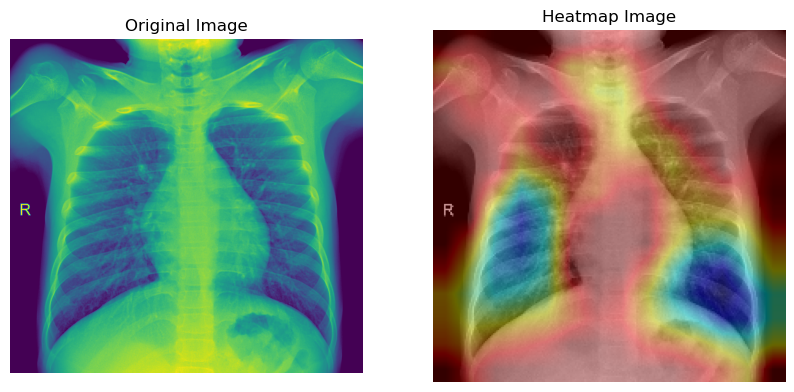

In [33]:
# Provide the path to the image you want to test
image_path = "../Data/Covid_Data_GradientCrescent/all/train/normal/NORMAL2-IM-1287-0001.jpeg"

# Provide the layer name of the last convolutional layer
last_conv_layer_name = "block5_conv3"

# Call the get_heatmap function
heatmap_image = get_heatmap(model, image_path, last_conv_layer_name)

# Display the original image and the heatmap image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5)

# Load and display the original image
original_image = mpimg.imread(image_path)
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display the heatmap image
axs[1].imshow(heatmap_image)
axs[1].axis('off')
axs[1].set_title('Heatmap Image')

plt.show()

In [32]:
import cv2
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

def get_heatmap(model, img_path, layer_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    heatmap_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = heatmap_model(img)
        pred_class = np.argmax(predictions[0])
        loss = predictions[:, pred_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = np.squeeze(heatmap)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img[0]) 
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

    return superimposed_img


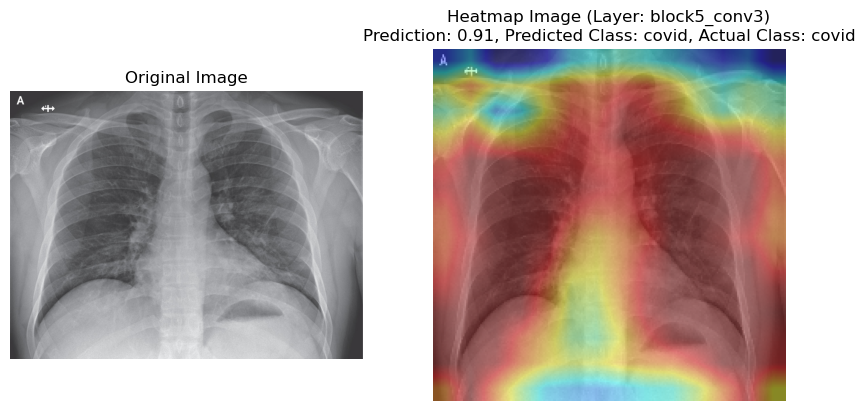

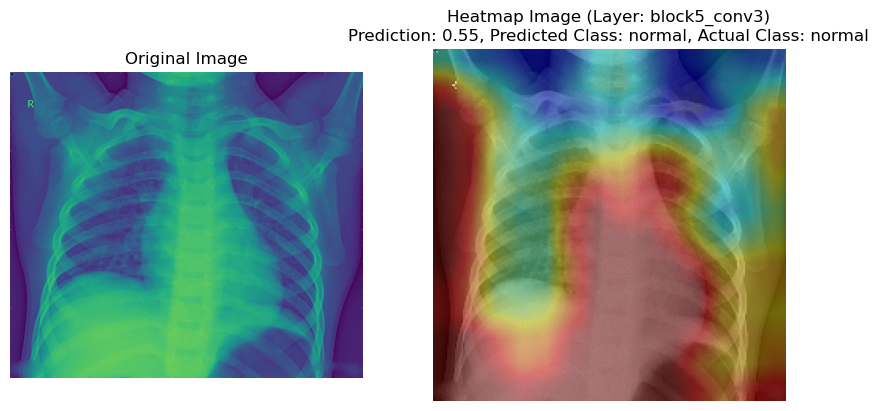

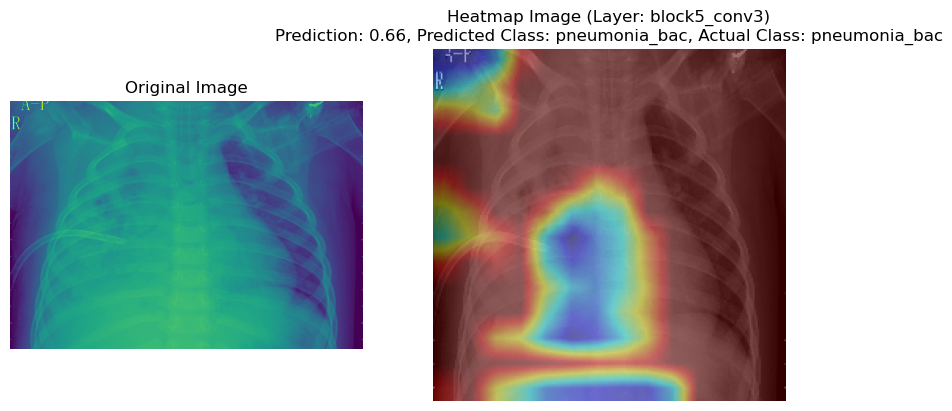

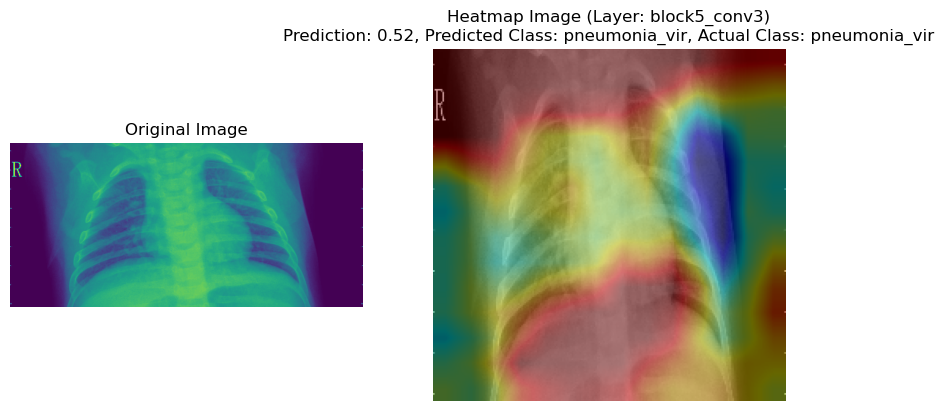

In [31]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Provide the path to the test dataset directory
test_dataset_path = '../Data/Covid_Data_GradientCrescent/all/test'

# Get the list of classes in the test dataset
classes = ['covid', 'normal', 'pneumonia_bac', 'pneumonia_vir']

# Iterate over each class
for class_name in classes:
    # Get the list of images in the current class
    images = os.listdir(os.path.join(test_dataset_path, class_name))
    
    # Select one image from the current class
    image_path = os.path.join(test_dataset_path, class_name, images[0])
    
    # Iterate over each convolutional layer in the model
    # superimposed_img = get_heatmap(model, image_path, 'block5_conv3')
    for layer in model.layers:
        if layer.name == 'block5_conv3':
            layer_name = layer.name
            
            # Generate heatmap for the current convolutional layer and image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            img = np.expand_dims(img, axis=0)

            heatmap_model = tf.keras.models.Model([model.inputs], [layer.output, model.output])

            with tf.GradientTape() as tape:
                conv_outputs, predictions = heatmap_model(img)
                pred_class = np.argmax(predictions[0])
                loss = predictions[:, pred_class]

            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

            heatmap = np.maximum(heatmap, 0)
            heatmap /= np.max(heatmap)
            heatmap = np.squeeze(heatmap)
            heatmap = cv2.resize(heatmap, (224, 224))
            heatmap = np.uint8(255 * heatmap)

            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            img_uint8 = np.uint8(255 * img[0]) 
            superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)

            # Display the original image and the heatmap image
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            fig.subplots_adjust(hspace=0.5)

            # Load and display the original image
            original_image = mpimg.imread(image_path)
            axs[0].imshow(original_image)
            axs[0].axis('off')
            axs[0].set_title('Original Image')

            # Display the heatmap image with prediction probability, predicted class, and actual class as the title
            axs[1].imshow(superimposed_img)
            axs[1].axis('off')
            axs[1].set_title(f'Heatmap Image (Layer: {layer_name})\nPrediction: {predictions[0][pred_class]:.2f}, Predicted Class: {classes[pred_class]}, Actual Class: {class_name}')

            plt.show()


<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->